### Construct Utility Matrix 

In [8]:
import numpy as np
import pandas as pd
import os.path
from random import randint

ratings_file = './data/ratings.csv'
predictions_file = './data/predictions.csv'

ratings_description = pd.read_csv(ratings_file, delimiter=';',
                                  dtype={'userID': 'int', 'movieID': 'int', 'rating': 'int'},
                                  names=['userID', 'movieID', 'rating'])

num_movies = max(ratings_description["movieID"])
num_users = max(ratings_description["userID"])
R = np.zeros(( num_movies, num_users))

for user, movie, rating in ratings_description.values:
    R[movie-1, user-1] = rating

R[R==0] = np.nan
print(f"Shape of Utility matrix is (movies, users): {R.shape}")
R

Shape of Utility matrix is (movies, users): (3706, 6040)


array([[ 5., nan, nan, ..., nan, nan,  3.],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

## "Normal" Latent Factor Model

In [6]:
from numpy import genfromtxt

# Loaded from Latent_Factors_Basic.ipynb
Q_lf = genfromtxt("./latent_factors/Q.csv")
P_lf = genfromtxt("./latent_factors/P.csv")
objective_lf = genfromtxt("./latent_factors/objectives.csv")[:600]

## Latent Factors with Regularization

In [ ]:
from numpy import genfromtxt

# Loaded from Latent_Factors_Regularized.ipynb
Q_reg = genfromtxt("./lf_reg/Q.csv")
P_reg= genfromtxt("./lf_reg/P.csv")
objective_reg = genfromtxt("./lf_reg/objectives.csv")

## Latent Factors with Stochastic Gradient Descent (regularized)

In [8]:
from numpy import genfromtxt

# Loaded from Latent_Factors_SGD_Regularized.ipynb
Q_sgd = genfromtxt("./lf_sgd/Q.csv")
P_sgd= genfromtxt("./lf_sgd/P.csv")
objective_sgd = genfromtxt("./lf_sgd/objectives.csv")

## Latent Factor (SGD + biases + regularization)

In [ ]:
from tqdm.auto import tqdm

EPOCHS = 500
LEARNING_RATE = 0.0001
LAMBDA = 0.1
LAMBDA_bias = 0.02


K = 2 # number of factors to work with.

np.random.seed(42)

ratings = ratings_description.values.copy()
ratings[:, 0:2] = ratings[:, 0:2] - 1

# user movie interaction
Q = np.random.uniform(-1, 1, (R.shape[0], K)) # movies
P = np.random.uniform(-1, 1, (K, R.shape[1])) # users

# biases
tmp_R = np.nan_to_num(R)
overall_bias = np.mean(tmp_R[tmp_R!=0])

user_bias = [np.mean(user_ratings[user_ratings!=0]) for user_ratings in tmp_R.T] - overall_bias

movie_bias = [np.mean(movie_ratings[movie_ratings!=0]) for movie_ratings in tmp_R] - overall_bias 

overall_bias = np.ones((num_movies, num_users)) * overall_bias

div = (R.shape[0] * R.shape[1]) - np.isnan(R).sum()
RMSE = np.sqrt(((np.nan_to_num(R - np.matmul(Q, P), 0)**2).sum())/div)
print(f"Starting RMSE: {RMSE}")

bias_learning_curve = []
for epoch in tqdm(range(EPOCHS)):
    np.random.shuffle(ratings) # inplace shuffle of matrix
    R_pred = overall_bias + np.tile(user_bias, (num_movies, 1)) +  np.tile(movie_bias, (num_users, 1)).T + np.matmul(Q, P)
    curr_error = 2*np.nan_to_num(R - R_pred, 0)
    for userID, movieID, rating in ratings:
        q_update = LEARNING_RATE * (curr_error[movieID, userID]*P[:, userID] - LAMBDA*Q[movieID, :])
        Q[movieID, :] = Q[movieID, :] + q_update

        p_update = LEARNING_RATE * (curr_error[movieID, userID]*Q[movieID, :] - LAMBDA*P[:, userID])
        P[:, userID] = P[:, userID] + p_update
        
        movie_bias_update = LEARNING_RATE * (curr_error[movieID,userID] - LAMBDA_bias*movie_bias[movieID])
        movie_bias[movieID] = movie_bias[movieID] + movie_bias_update
        
        user_bias_update = LEARNING_RATE * (curr_error[movieID, userID] - LAMBDA_bias*user_bias[userID])
        user_bias[userID] = user_bias[userID] + user_bias_update
    
    R_pred_post = overall_bias + np.tile(user_bias, (num_movies, 1)) +  np.tile(movie_bias, (num_users, 1)).T + np.matmul(Q, P)
    RMSE_i = np.sqrt(((np.nan_to_num(R - R_pred_post, 0)**2).sum())/div)
    print(f"RMSE {epoch}: {RMSE_i}")
    bias_learning_curve.append([epoch, RMSE_i])

RMSE = np.sqrt(((np.nan_to_num(R - np.matmul(Q, P), 0)**2).sum())/div)
print(f"Final RMSE: {RMSE}")

Starting RMSE: 3.781830053581588


RMSE 0: 1.0189132585578011
RMSE 1: 1.0023154742202245
RMSE 2: 0.9893290422260702
RMSE 3: 0.9789260538686573
RMSE 4: 0.970430384444999
RMSE 5: 0.9633779661290109
RMSE 6: 0.9574400443258727
RMSE 7: 0.9523785686409296
RMSE 8: 0.9480171233690567
RMSE 9: 0.9442229914915569
RMSE 10: 0.9408940143188137
RMSE 11: 0.9379509778302525
RMSE 12: 0.9353314350474802
RMSE 13: 0.9329855779222762
RMSE 14: 0.9308731271352564
RMSE 15: 0.9289613193656109
RMSE 16: 0.9272232021126601
RMSE 17: 0.9256364249429441
RMSE 18: 0.9241822097019474
RMSE 19: 0.9228448804285356
RMSE 20: 0.921610988692758
RMSE 21: 0.9204691215301837
RMSE 22: 0.919409498357345
RMSE 23: 0.918423638857601
RMSE 24: 0.9175041617515156
RMSE 25: 0.9166446928963514
RMSE 26: 0.9158396111631483
RMSE 27: 0.9150839714414126
RMSE 28: 0.914373407275207
RMSE 29: 0.913704086891912
RMSE 30: 0.9130725492323789
RMSE 31: 0.9124757330860465
RMSE 32: 0.9119108922064375
RMSE 33: 0.9113755684543751
RMSE 34: 0.9108675345290439
RMSE 35: 0.9103847949216529
RMSE 36:

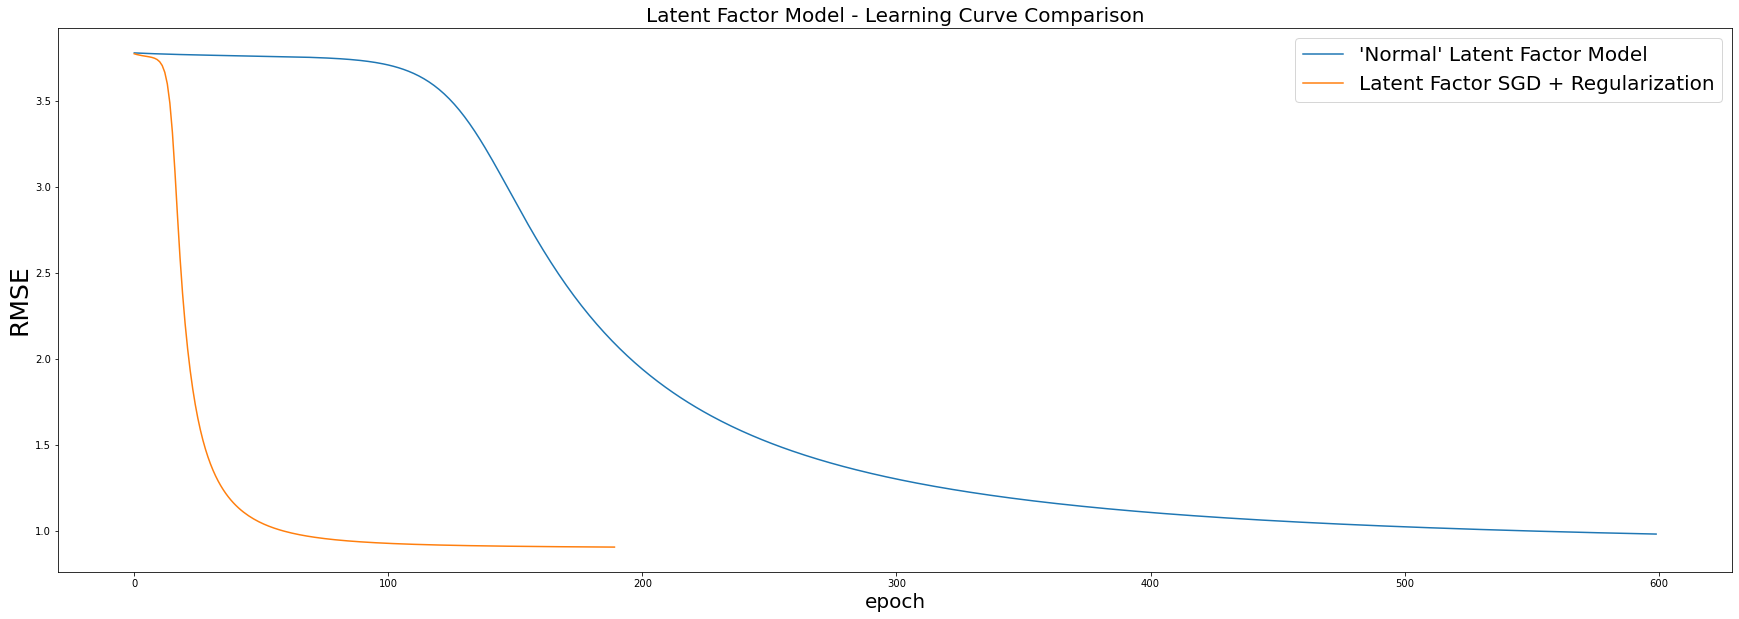

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 10))
plt.title("Latent Factor Model - Learning Curve Comparison", fontsize=20)
plt.xlabel("epoch", fontsize=20)
plt.ylabel("RMSE", fontsize=25)
plt.plot(objective_lf[:, 0], objective_lf[:, 1], label="'Normal' Latent Factor Model")
# plt.plot(objective_reg[:, 0], objective_reg[:, 1], label="Latent Factor w. Regularization")
plt.plot(objective_sgd[:190, 0], objective_sgd[:190, 1], label="Latent Factor SGD + Regularization")
# plt.plot(bias_learning_curve[:, 0], bias_learning_curve[:, 1], label="Latent Factor SGD + Regularization + bias")
plt.legend(loc="upper right", prop={'size': 20})
plt.show()

In [47]:
#### CREATE SUBMISSION ####
predictions_description = pd.read_csv(predictions_file, delimiter=';', names=['userID', 'movieID'], header=None)
submission = []
R_pred = np.matmul(Q, P)
for i, [user,movie] in enumerate(predictions_description.values):
    submission.append([i+1, R_pred[movie-1,user-1]])

submission_df = pd.DataFrame(submission, columns=["Id", "Rating"])
submission_df.to_csv("data/submission.csv", index=False)